In [2]:
import pandas as pd 
from langdetect import detect
import tensorflow as tf
from transformers import BertConfig, AutoTokenizer, TFBertModel, BertTokenizer, TFBertForSequenceClassification, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import hamming_loss


2023-09-18 13:57:50.777266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data=pd.read_csv('../raw_data/measuring_hate_speech.csv')


In [4]:
word='annotator'
columns_to_drop = [col for col in data.columns if word in col]
data.drop(columns=columns_to_drop, inplace=True)

In [5]:
data.shape

(135556, 71)

In [6]:
columns_to_exclude=['comment_id','platform','sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize',
       'violence', 'genocide', 'attack_defend', 'hatespeech','infitms', 'outfitms', 'std_err',
       'hypothesis']
selected_columns=[col for col in data.columns if col not in columns_to_exclude]
data_1=data[selected_columns]


In [7]:
# Extract column names with labels "False" and "Right"

# Extract column names with labels "False" and "Right"
columns_to_sum = ['target_gender_men',
       'target_gender_non_binary','target_gender_transgender_men',
       'target_gender_transgender_unspecified',
       'target_gender_transgender_women',
       'target_gender_other']

# Sum the values in the selected columns
data_1['target_gender_without_women'] = data_1[columns_to_sum].sum(axis=1)



/var/folders/r_/7c9slj0d4cq70zs43b75t3f80000gn/T/ipykernel_29560/1607479923.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['target_gender_without_women'] = data_1[columns_to_sum].sum(axis=1)


In [8]:
columns_of_interest = ['text','hate_speech_score','target_race', 'target_religion', 'target_origin', 'target_gender_women','target_gender_without_women','target_sexuality','target_age','target_disability']

data_1=data_1[columns_of_interest] 


In [9]:


data_1['target_gender_without_women']=data_1['target_gender_without_women'].replace(0,False)
data_1['target_gender_without_women']=data_1['target_gender_without_women'].replace(1,True)
data_1['target_gender_without_women']=data_1['target_gender_without_women'].replace(2,True)
data_1['target_gender_without_women']=data_1['target_gender_without_women'].replace(3,True)
data_1['target_gender_without_women']=data_1['target_gender_without_women'].replace(4,True)
data_1['target_gender_without_women']=data_1['target_gender_without_women'].replace(5,True)
data_1['target_gender_without_women']=data_1['target_gender_without_women'].replace(6,True)
data_1['target_gender_without_women'].unique()


array([False,  True])

In [10]:
data_1['target_race'].unique()

array([ True, False])

In [11]:
#data_1= data_1.astype(bool)
#type(data_1['target_race'][0])

In [12]:
data_1['target_gender_without_women'] = data_1['target_gender_without_women'].apply(lambda x: x.replace("0", "False") if isinstance(x, str) else x)
data_1['target_gender_without_women'] = data_1['target_gender_without_women'].apply(lambda x: x.replace("1", "True") if isinstance(x, str) else x)

In [13]:
count_df= pd.DataFrame(data_1.drop(['text','hate_speech_score'],axis=1).sum(axis=1)).rename({0:'count'},axis=1)

In [14]:
count_df[count_df['count']>1].sum()/len(count_df)

count    0.479366
dtype: float64

In [15]:
data_1.drop(columns ="hate_speech_score", inplace = True)

data_1.rename(columns={'target_race': 'racism',
              'target_religion': 'religion',
              'target_origin': 'xenophobia',
              'target_gender_women':'misogyny',
              'target_gender_without_women':'transphobia',
              'target_sexuality': 'homophobia',
              'target_age': 'ageism',
              'target_disability':'validism'}, inplace = True )


In [16]:
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

# Appliquez la fonction pour filtrer les textes en anglais
data_1 = data_1[data_1['text'].apply(is_english)]
data_1

,text,racism,religion,xenophobia,misogyny,transphobia,homophobia,ageism,validism
0,Yes indeed. She sort of reminds me of the elde...,True,False,False,False,False,False,False,False
1,The trans women reading this tweet right now i...,False,False,False,False,True,False,False,False
2,Question: These 4 broads who criticize America...,False,False,True,False,False,False,False,False
3,It is about time for all illegals to go back t...,False,False,True,False,False,False,False,False
4,For starters bend over the one in pink and kic...,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...
135550,@AbeShinzo @realDonaldTrump @shinzoabe 独裁者は行きま...,True,True,False,False,False,False,False,False
135552,Millions of #Yemen-is participated in mass ral...,True,True,False,False,False,False,False,False
135553,@AbeShinzo @realDonaldTrump @shinzoabe 独裁者は行きま...,False,True,True,False,False,False,False,False
135554,Millions of #Yemen-is participated in mass ral...,False,True,False,False,False,False,False,False


In [17]:
data_extracted=data_1[0:1000]
data_extracted

,text,racism,religion,xenophobia,misogyny,transphobia,homophobia,ageism,validism
0,Yes indeed. She sort of reminds me of the elde...,True,False,False,False,False,False,False,False
1,The trans women reading this tweet right now i...,False,False,False,False,True,False,False,False
2,Question: These 4 broads who criticize America...,False,False,True,False,False,False,False,False
3,It is about time for all illegals to go back t...,False,False,True,False,False,False,False,False
4,For starters bend over the one in pink and kic...,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...
1003,I would eat your pussy and fuck you till you h...,False,False,False,True,False,False,False,False
1004,You are just as fucking retarded as the dumb t...,False,False,False,False,False,False,False,True
1005,Only issue is I hate pussies like you masquera...,False,False,False,False,True,False,False,False
1006,@RealCandaceO @ScherieMurray @AOC ...and @Real...,False,False,False,True,False,False,False,False


In [18]:
# Step 1: Data Preparation
# Load and preprocess your dataset (replace with your data loading code)

texts = data_extracted['text']

labels = data_extracted.drop(['text'],axis=1)

In [19]:
texts.shape

(1000,)

In [20]:
labels.shape

(1000, 8)

In [21]:
text_to_encode=texts.values.tolist()

/Users/irismarechal/.pyenv/versions/3.10.6/envs/moder_ia/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/irismarechal/.pyenv/versions/3.10.6/envs/moder_ia/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


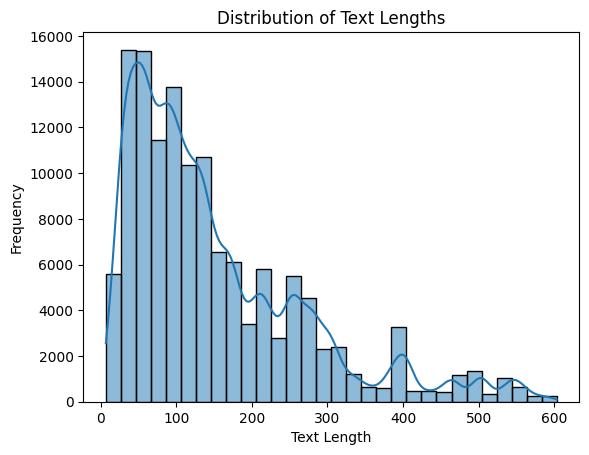

In [22]:
# Assuming you have a DataFrame named 'data' and a column named 'text_column' containing text
# Calculate the lengths of the text in the 'text_column' and store them in a new column 'text_length'
data_1['text_length'] = data_1['text'].apply(len)

# Create a distribution plot using Seaborn
sns.histplot(data=data_1, x=data_1['text_length'], bins=30, kde=True)

# Add labels and title
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')

# Show the plot
plt.show()







In [23]:
len(text_to_encode)

1000

In [24]:
# Split test set 
train_inputs, test_inputs, train_labels, test_labels = train_test_split(text_to_encode, labels, test_size=0.3, random_state=42)

In [25]:
# Encode text data into BERT-friendly format

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_inputs_tokenized=tokenizer(train_inputs, add_special_tokens=True, truncation=True, max_length=200, padding='max_length', return_attention_mask=True, return_tensors='tf')

test_inputs_tokenized=tokenizer(test_inputs, add_special_tokens=True, truncation=True, max_length=200, padding='max_length', return_attention_mask=True, return_tensors='tf')

train_inputs_tuple = (train_inputs_tokenized['input_ids'], train_inputs_tokenized['token_type_ids'], train_inputs_tokenized['attention_mask'])
test_inputs_tuple = (test_inputs_tokenized['input_ids'], test_inputs_tokenized['token_type_ids'], test_inputs_tokenized['attention_mask'])



In [26]:
unique_classes = set()

for label in labels:
    unique_classes.update(label)

num_classes = len(unique_classes)

In [27]:
num_classes

19

In [28]:
# Step 2: Model Building
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=8)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.BinaryCrossentropy()
# Compile the model
model.compile(optimizer=optimizer, loss=loss)

In [30]:
train_labels.shape

(700, 8)

In [31]:
history = model.fit(
    train_inputs_tuple,train_labels,
    epochs=1,  
    batch_size=32)

22/22 [==============================] - 471s 20s/step - loss: 0.8881


In [32]:
train_predictions = model.predict(train_inputs_tuple)
test_predictions = model.predict(test_inputs_tuple)




10/10 [==============================] - 58s 6s/step


In [33]:
# Calculate Hamming Loss for train and test separately
metric = HammingLoss(mode='multiclass', threshold=0.6)
hamming_loss_train_model=metric.update_state(train_labels, train_predictions)
hamming_loss_test_model=metric.update_state(est_labels, test_predictions)
hamming_loss_train_model

NameError: name 'HammingLoss' is not defined

In [ ]:
tfa.metrics.HammingLoss(
    mode: str,
    name: str = 'hamming_loss',

    **kwargs
)

In [41]:
# Step 5: Inference
# You can use the trained model for inference on new text data
input = input("Rentrez un nouveau tweet")
new_texts=pd.DataFrame["input"] 


TypeError: 'str' object is not callable

In [ ]:
new_texts_tokenized=tokenizer(new_text, add_special_tokens=True, truncation=True, max_length=200, padding='max_length', return_attention_mask=True, return_tensors='tf')

new_prediction=model.predict(new_texts_tokenized)
new_prediction

In [ ]:
# Make predictions on new text data
new_predictions = model.predict([new_input_ids, new_attention_masks])